# STS dataset EDA

In [17]:
import pandas as pd
import re
from matplotlib import pyplot as plt

from tqdm import tqdm
from transformers import AutoTokenizer

import plotly
import plotly.express as px # plotly jupyterlab에서 안 되는 듯..
import seaborn as sns

## 살펴보기

In [2]:
train = pd.read_csv('train.csv', sep=',')
dev = pd.read_csv('dev.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')

print('train set len: ', len(train))
print('dev set len: ', len(dev))
print('test set len: ', len(test))

train set len:  9324
dev set len:  550
test set len:  1100


In [3]:
print(train.describe())
print(dev.describe())
# print(test.describe())

             label  binary-label
count  9324.000000   9324.000000
mean      1.849968      0.389532
std       1.602212      0.487670
min       0.000000      0.000000
25%       0.200000      0.000000
50%       1.600000      0.000000
75%       3.400000      1.000000
max       5.000000      1.000000
            label  binary-label
count  550.000000    550.000000
mean     2.584000      0.520000
std      1.459483      0.500055
min      0.000000      0.000000
25%      1.400000      0.000000
50%      2.600000      1.000000
75%      3.800000      1.000000
max      5.000000      1.000000


## 칼럼 구성
- sentence_1: 첫 번째 문장 (str)
- sentence_2: 두 번째 문장 (str)
- label: sentence_1 과 sentence_2의 의미적 유사도 (float)
- binary-label: sentence_1 과 sentence_2의 의미 유사 여부 (float)

In [4]:
train.sample(5)

,id,source,sentence_1,sentence_2,label,binary-label
579,boostcamp-sts-v1-train-579,petition-sampled,김성수 동생 강력 처벌 (사형),살인범 김성수 동생도 강력하게처벌하십시요,3.4,1.0
6101,boostcamp-sts-v1-train-6101,nsmc-sampled,최고의 드라마..ㅎㅎ,시즌 모두 최고의 드라마....,3.2,1.0
8294,boostcamp-sts-v1-train-8294,nsmc-sampled,마지막 장면은 진짜 멋있던데 굿굿,마지막 장면은 정말 고통스러웠다.,1.0,0.0
9133,boostcamp-sts-v1-train-9133,slack-sampled,주말 마무리 잘 하세요,하루 잘 마무리하세요~~,1.8,0.0
8104,boostcamp-sts-v1-train-8104,nsmc-sampled,내가 왜 이런걸 보고있나 싶을정도로 한심해짐..,내가 왜 이걸 봤지...,2.6,1.0


In [5]:
dev.sample(5)

,id,source,sentence_1,sentence_2,label,binary-label
151,boostcamp-sts-v1-dev-151,petition-sampled,유은혜교육부총리 적극 지지합니다,"비리유치원의 장상화, 유은혜 장관을 지지합니다.",2.8,1.0
413,boostcamp-sts-v1-dev-413,nsmc-rtt,아무 주제를 찾을 수 없는 영화,주제를 찾을 수 없는 영화,4.2,1.0
184,boostcamp-sts-v1-dev-184,petition-sampled,"대통령님, 저희 모녀 좀 도와 주세요","대통령님, 저희 스킨푸드 좀 꼭! 살려주세요.",0.6,0.0
182,boostcamp-sts-v1-dev-182,nsmc-rtt,역시 스탠리 큐브릭. 최고다,역시 스탠리 큐브릭. 최고,4.6,1.0
170,boostcamp-sts-v1-dev-170,petition-rtt,제발 아무것도‥하지마세요,제발 아무것도 하지마...,4.5,1.0


In [6]:
test.sample(5)

,id,source,sentence_1,sentence_2
760,boostcamp-sts-v1-test-760,petition-rtt,"준비됐다고 한 대통령들, 다 교도소 간데 대한 물음","준비가 됐다고 말하는 대통령들, 모두 감옥에 가는 것에 대해 물었습니다."
178,boostcamp-sts-v1-test-178,petition-sampled,이명박은 출금해야 합니다!!!,이명박 일가 강하게 수사해 주세요!!!
139,boostcamp-sts-v1-test-139,petition-sampled,부동산 상하한제를 제안합니다,부동산 호가 제한제를 제안합니다.
970,boostcamp-sts-v1-test-970,nsmc-sampled,보지는 않았지만 평점이 낮아서 점수 줌,영화 괜찮은데 평점이 낮아서 올려야겠음
379,boostcamp-sts-v1-test-379,petition-rtt,청와대 온라인 시위 차단,"청와대, 온라인 시위 차단"


## 토크나이징 분석

In [7]:
# 입력의 두 문장을 토크나이징하여 길이와 unk 토큰의 개수를 분석합니다
def tokenizing(df):
    tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')

    sentence1_len = []
    sentence2_len = []
    sentence1_unk = []
    sentence2_unk = []
    sentence1_tokenized = []
    sentence2_tokenized = []
    for i, item in df.iterrows():
        sentence1 = tokenizer(item['sentence_1'])['input_ids']
        sentence2 = tokenizer(item['sentence_2'])['input_ids']
        
        sentence1_tokenized.append(tokenizer.decode(sentence1))
        sentence2_tokenized.append(tokenizer.decode(sentence2))
        
        sentence1_len.append(len(sentence1))
        sentence2_len.append(len(sentence2))

        sentence1_unk.append(sentence1.count(tokenizer.unk_token_id))
        sentence2_unk.append(sentence2.count(tokenizer.unk_token_id))

    tokenized_df = pd.DataFrame([sentence1_tokenized, sentence2_tokenized, sentence1_len, sentence2_len, sentence1_unk, sentence2_unk]).transpose()
    tokenized_df.columns = ['sentence1_tokenized', 'sentence2_tokenized', '1_len', '2_len', '1_unk', '2_unk']
    print(tokenized_df.describe())
    
    return tokenized_df

In [8]:
print("train")
train_tokenized = tokenizing(train)

print("dev")
dev_tokenized = tokenizing(dev) 

print("test")
test_tokenized = tokenizing(test)

train
       sentence1_tokenized sentence2_tokenized  1_len  2_len  1_unk  2_unk
count                 9324                9324   9324   9324   9324   9324
unique                9318                9313     57     57      5      3
top      [CLS] [UNK] [SEP]   [CLS] [UNK] [SEP]     10     11      0      0
freq                     7                   8    918    897   9067   9128
dev
                 sentence1_tokenized  \
count                            550   
unique                           550   
top     [CLS] 액션은개뿔 총몇번쏘고 끝입니다 [SEP]   
freq                               1   

                               sentence2_tokenized  1_len  2_len  1_unk  2_unk  
count                                          550    550    550    550    550  
unique                                         550     43     39      3      2  
top     [CLS] 액션은 흉내만 내고 그마저도 후반부에는 슬로우모션 처리 [SEP]      9      9      0      0  
freq                                             1     70     66    535    538  
test
    

In [9]:
# 어떤 토큰이 UNK 처리되었는지 파악해보자. (Train)
train_tokenized_df = train_tokenized.merge(train, left_index=True, right_index=True, how='left')
train_tokenized_df[(train_tokenized_df['1_unk'] > 0) | (train_tokenized_df['2_unk'] > 0)][['sentence_1', 'sentence1_tokenized', 'sentence_2', 'sentence2_tokenized', 'label']]

,sentence_1,sentence1_tokenized,sentence_2,sentence2_tokenized,label
1,앗 제가 접근권한이 없다고 뜹니다;;,[CLS] 앗 제가 접근권한이 없다고 [UNK] ; ; [SEP],"오, 액세스 권한이 없다고 합니다.","[CLS] 오, 액세스 권한이 없다고 합니다. [SEP]",4.2
5,오마이가뜨지져스크롸이스트휏,[CLS] [UNK] [SEP],오 마이 갓 지저스 스크론 이스트 팬,[CLS] 오 마이 갓 지저스 스크론 이스트 팬 [SEP],2.6
158,처음 뵌 분들과 빠르게 친해질 수 있을 것 같은 느낌!,[CLS] 처음 [UNK] 분들과 빠르게 친해질 수 있을 것 같은 느낌! [SEP],처음 만나는 사람들과 금방 친해질 수 있는 것 같아요!,[CLS] 처음 만나는 사람들과 금방 친해질 수 있는 것 같아요! [SEP],3.4
187,와아아아안전 좋아요오오,[CLS] 와아아아안전 좋아요오오 [SEP],꺄오오올!!!!! 환영합니다아아아,[CLS] [UNK]!!!!! 환영합니다아아아 [SEP],0.0
227,수지 목소리 너무좋아ㅜㅜㅜ,[CLS] 수지 목소리 너무좋아ㅜㅜㅜ [SEP],소소한재미ㅜㅋ여탯껏삶을다시돌아보게하는영화ㅜ,[CLS] [UNK] [SEP],0.0
...,...,...,...,...,...
9263,아니나다를까 반전이라고 하기도 뭐하고 끝도 영찝찝하고 시간 아깝네,[CLS] 아니나다를까 반전이라고 하기도 뭐하고 끝도 [UNK] 시간 아깝네 [SEP],영화라고 하기에도 참 부끄럽다.,[CLS] 영화라고 하기에도 참 부끄럽다. [SEP],1.0
9264,"인터넷을 이용한 거짓 선동과 명예홰손, 영리를 위한 거짓 후기 작성을 막을 수 있는...","[CLS] 인터넷을 이용한 거짓 선동과 [UNK], 영리를 위한 거짓 후기 작성을 ...","인터넷을 이용하여 허위선동, 비방, 허위리뷰를 작성하는 행위를 방지하기 위한 특례법...","[CLS] 인터넷을 이용하여 허위선동, 비방, 허위리뷰를 작성하는 행위를 방지하기 ...",3.8
9292,히히힛히힛히히히힛힛,[CLS] [UNK] [SEP],우히히히 완전 잼있어,[CLS] 우히히히 완전 잼있어 [SEP],1.4
9300,너무 재미있게 봣습니다. 추천,[CLS] 너무 재미있게 [UNK]. 추천 [SEP],영화 너무 재미있게 봤구요.,[CLS] 영화 너무 재미있게 봤구요. [SEP],3.4


아래와 같은 경우, 문장 전체가 [UNK] 처리가 된다. <br>
보통 띄어쓰기가 잘 안 되어 있는 데이터에서 이러한 현상이 발생한다. <br>
**전처리 단계에서 띄어쓰기를 강제로 적용해줄 필요가 있다.**

In [10]:
train_tokenized_df.iloc[227,:]

sentence1_tokenized    [CLS] 수지 목소리 너무좋아ㅜㅜㅜ [SEP]
sentence2_tokenized             [CLS] [UNK] [SEP]
1_len                                           9
2_len                                           3
1_unk                                           0
2_unk                                           1
id                     boostcamp-sts-v1-train-227
source                               nsmc-sampled
sentence_1                         수지 목소리 너무좋아ㅜㅜㅜ
sentence_2                소소한재미ㅜㅋ여탯껏삶을다시돌아보게하는영화ㅜ
label                                         0.0
binary-label                                  0.0
Name: 227, dtype: object

In [11]:
# 어떤 토큰이 UNK 처리되었는지 파악해보자. (dev)
dev_tokenized_df = dev_tokenized.merge(dev, left_index=True, right_index=True, how='left')
dev_tokenized_df[(dev_tokenized_df['1_unk'] > 0) | (dev_tokenized_df['2_unk'] > 0)][['sentence_1', 'sentence1_tokenized', 'sentence_2', 'sentence2_tokenized', 'label']]

,sentence_1,sentence1_tokenized,sentence_2,sentence2_tokenized,label
33,여기에 청원글 열심히 써봣자 아무것도 안바뀌니까 고생하며 글쓰지말고 나가세요 여러분,[CLS] 여기에 청원글 열심히 [UNK] 아무것도 안바뀌니까 고생하며 글쓰지말고 ...,가상화폐투기분들 여기에 글그만 올리고 그만들 빠져나오세요,[CLS] 가상화폐투기분들 여기에 글그만 올리고 그만들 빠져나오세요 [SEP],0.8
37,조만간 또 오프에서 뵈어요 ㅎㅎㅎ,[CLS] 조만간 또 오프에서 뵈어요 ㅎㅎㅎ [SEP],네! ㅋㅋ 아님 다음에 오프에서 뵐때 제꺼 체험해보세요 ㅋㅋ,[CLS] 네! ㅋㅋ 아님 다음에 오프에서 [UNK] 제꺼 체험해보세요 ㅋㅋ [SEP],1.8
42,학기 잘 마무리하시고 다음에 기회 되면 또 뵀으면 좋겠습니다,[CLS] 학기 잘 마무리하시고 다음에 기회 되면 또 [UNK] 좋겠습니다 [SEP],일하면서 길게 얘기할 기회가 많지 않았는데 다음에 또 뵀으면 좋겠습니다,[CLS] 일하면서 길게 얘기할 기회가 많지 않았는데 다음에 또 [UNK] 좋겠습니...,2.2
77,다음에 또 뵐게요~~,[CLS] 다음에 또 [UNK] ~ ~ [SEP],다음에 또 뵐게요~~~,[CLS] 다음에 또 [UNK] ~ ~ ~ [SEP],5.0
137,오늘은 하이브 (전 빅히트) 의 자회사인 쏘스뮤직에서 르세라핌 이 첫 곡 낸다고도 ...,[CLS] 오늘은 하이브 ( 전 빅히트 ) 의 자회사인 쏘스뮤직에서 [UNK] 이 ...,오늘 르세라핌은 하이브(구 빅히트)의 자회사인 쏘스뮤직에서 첫 번째 곡을 발매한다고...,[CLS] 오늘 [UNK] 하이브 ( 구 빅히트 ) 의 자회사인 쏘스뮤직에서 첫 번...,4.5
153,비록 화상이지만 만나봬서 너무 반가웠습니다 .,[CLS] 비록 화상이지만 [UNK] 너무 반가웠습니다. [SEP],오랜만에 봬서 너무 반가웠습니다,[CLS] 오랜만에 [UNK] 너무 반가웠습니다 [SEP],2.8
154,남들과다르다는이유만으로 억울한 죽음을 당한 브랜든 티나의 명복을 빕니다,[CLS] 남들과다르다는이유만으로 억울한 죽음을 당한 브랜든 티나의 명복을 [UNK...,다른 사람들과 다르다는 이유로 부당한 죽음을 당하신 나머지 Brandon Tina를...,[CLS] 다른 사람들과 다르다는 이유로 부당한 죽음을 당하신 나머지 Brandon...,4.6
163,오늘 안에 가장 많은 표를 받으신 분께는 상품권을 전달드리도록 하겠습니다!,[CLS] 오늘 안에 가장 많은 표를 받으신 분께는 상품권을 전달드리도록 하겠습니다...,채택된 아이디어를 내주시는 분께는 을 보내드리겠습니다아~ㅊㅋㅊㅋ!!,[CLS] 채택된 아이디어를 내주시는 분께는 을 보내드리겠습니다아 ~ [UNK]!!...,1.5
167,진지함과 유머러스함이균형적으로 다뤄진 연출력과연기..... 그냥 짱 재밌다.,[CLS] 진지함과 유머러스함이균형적으로 다뤄진 연출력과연기..... 그냥 짱 재밌...,그냥.. 파워레인져같은거 영화같지도않게만듦...,[CLS] 그냥.. 파워레인져같은거 [UNK]... [SEP],0.0
186,#수경재배입문챕터 #파릇파릇,[CLS] # [UNK] # 파릇파릇 [SEP],#수경재배 입문서 #Greenery,[CLS] # 수경재배 입문서 # Greenery [SEP],3.2


In [12]:
# 어떤 토큰이 UNK 처리되었는지 파악해보자. (test)
test_tokenized_df = test_tokenized.merge(test, left_index=True, right_index=True, how='left')
test_tokenized_df[(test_tokenized_df['1_unk'] > 0) | (test_tokenized_df['2_unk'] > 0)][['sentence_1', 'sentence1_tokenized', 'sentence_2', 'sentence2_tokenized']]

,sentence_1,sentence1_tokenized,sentence_2,sentence2_tokenized
22,"여러가지 즐겁게 이야기 할 수 있었는데, 나중에 기회되면 또 뵙고 이야기 나누어요!","[CLS] 여러가지 즐겁게 이야기 할 수 있었는데, 나중에 기회되면 또 뵙고 이야기...",나중에 혹시나 독립하게 되면 여러가지 또 여쭙도록 하겠습니다!,[CLS] 나중에 혹시나 독립하게 되면 여러가지 또 [UNK] 하겠습니다! [SEP]
95,사운드트랙은 괜찮다만.,[CLS] 사운드트랙은 괜찮다만. [SEP],사운드트랙도좋고 볼거리가 정말 화려하다. 최첨단무기 뿅간다,[CLS] 사운드트랙도좋고 볼거리가 정말 화려하다. 최첨단무기 [UNK] [SEP]
113,세분 젠지V ! ㅋㅋ 스코어 모집요건이 있나욯ㅎㅎ,[CLS] 세분 젠지V! ㅋㅋ 스코어 모집요건이 [UNK] [SEP],수분젠지브이! ㅎㅎ 점수모집 조건이 있나요?,[CLS] 수분젠지브이! ㅎㅎ 점수모집 조건이 있나요? [SEP]
116,북한 열병식과 정부대응이 궁굼합니다.,[CLS] 북한 열병식과 정부대응이 [UNK]. [SEP],미세먼지에 대한 정부 대응 방법을 알고싶습니다.,[CLS] 미세먼지에 대한 정부 대응 방법을 알고싶습니다. [SEP]
125,ㅋㅋ 비욘드 미트 버거 입니다.,[CLS] ㅋㅋ [UNK] 미트 버거 입니다. [SEP],비욘드미트로 만든 버거 포함 여러 파스타와 플레이트 메뉴도 아주 맛있었어요.,[CLS] [UNK] 만든 버거 포함 여러 파스타와 플레이트 메뉴도 아주 맛있었어요...
133,생성 완료했숩니다!,[CLS] 생성 [UNK]! [SEP],생성 및 초대 완료~!,[CLS] 생성 및 초대 완료 ~! [SEP]
142,넵 확인 감사합니다!!,[CLS] [UNK] 확인 감사합니다!! [SEP],넵!ㅋㅋ 감사합니다~!,[CLS] [UNK]! ㅋㅋ 감사합니다 ~! [SEP]
229,크 나중에 한잔 하시죵 ㅎㅎㅎ,[CLS] 크 나중에 한잔 [UNK] ㅎㅎㅎ [SEP],클하 좋네요 ㅎㅎㅎ,[CLS] 클하 좋네요 ㅎㅎㅎ [SEP]
343,아무리 봐도 절대 안질리는 영화-음악,[CLS] 아무리 봐도 절대 안질리는 영화 - 음악 [SEP],기준은 아무리 봐도 안질리긔,[CLS] 기준은 아무리 봐도 [UNK] [SEP]
352,애들이어서 귀엽다 하고 보고 있는데 몇몃ㅈ 애들 말하는게 건방지네,[CLS] 애들이어서 귀엽다 하고 보고 있는데 [UNK] 애들 말하는게 건방지네 [...,애들이라서 귀엽다고 하는 걸 보고 있어,[CLS] 애들이라서 귀엽다고 하는 걸 보고 있어 [SEP]


## label 분포
- train set은 0점대 ~ 3.5점대의 데이터들이 대부분을 차지하고, dev set은 약 1.5~ 3.8 정도가 대부분을 차지함.
- 4~5점 대의 데이터 수가 부족함.

In [13]:
# source 종류 파악
print(f"train source unique : {sorted(train['source'].unique())}")
print(f"dev source unique : {sorted(dev['source'].unique())}")

train source unique : ['nsmc-rtt', 'nsmc-sampled', 'petition-rtt', 'petition-sampled', 'slack-rtt', 'slack-sampled']
dev source unique : ['nsmc-rtt', 'nsmc-sampled', 'petition-rtt', 'petition-sampled', 'slack-rtt', 'slack-sampled']


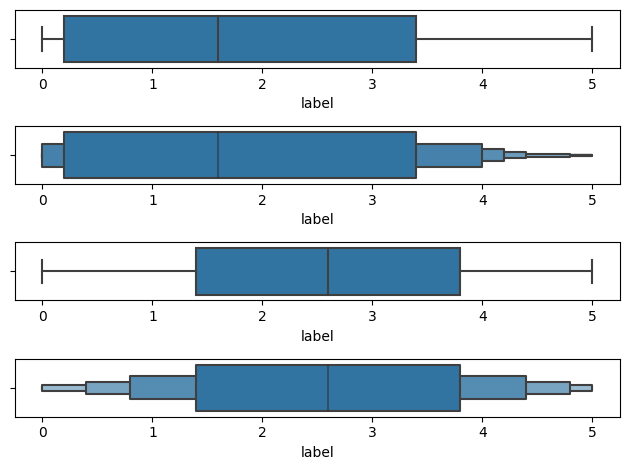

In [49]:
fig, ax = plt.subplots(nrows=4)
sns.boxplot(x='label', data=train, ax=ax[0], )
sns.boxenplot(x='label', data=train, ax=ax[1])

sns.boxplot(x='label', data=dev, ax=ax[2])
sns.boxenplot(x='label', data=dev, ax=ax[3])

plt.tight_layout()
plt.show()

## 이모지
- train set에 단 1건 존재.
- 전처리 때 지우면 좋을 듯.

In [ ]:
# 이모지 검출
EMOJI_PATTERN = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
)

train['emoji_list1'] = train['sentence_1'].apply(lambda x: EMOJI_PATTERN .findall(x))
dev['emoji_list1'] = dev['sentence_1'].apply(lambda x: EMOJI_PATTERN .findall(x))
test['emoji_list1'] = test['sentence_1'].apply(lambda x: EMOJI_PATTERN .findall(x))

train['emoji_list2'] = train['sentence_2'].apply(lambda x: EMOJI_PATTERN .findall(x))
dev['emoji_list2'] = dev['sentence_2'].apply(lambda x: EMOJI_PATTERN .findall(x))
test['emoji_list2'] = test['sentence_2'].apply(lambda x: EMOJI_PATTERN .findall(x))

In [21]:
print(train['emoji_list1'].apply(lambda x: len(x)).unique())
print(dev['emoji_list1'].apply(lambda x: len(x)).unique())
print(test['emoji_list1'].apply(lambda x: len(x)).unique())

print(train['emoji_list2'].apply(lambda x: len(x)).unique())
print(dev['emoji_list2'].apply(lambda x: len(x)).unique())
print(test['emoji_list2'].apply(lambda x: len(x)).unique())


[0]
[0]
[0]
[0 4]
[0]
[0]


In [22]:
# 이모지 포함 문장은 train set에 1건 존재.
# 전처리 때 지워버립시다!
train[train['emoji_list2'].apply(len) > 0]

,id,source,sentence_1,sentence_2,label,binary-label,emoji_list1,emoji_list2
387,boostcamp-sts-v1-train-387,slack-rtt,퐈이야!! 잘 마치시고 재충전타임 꼭 가지셨으면 좋겠어요~,👌👌👌👌 좋은 시간 보내시고 재충전의 시간 되시기 바랍니다!,2.2,0.0,[],"[👌, 👌, 👌, 👌]"
